# ALS, BPR Matrix Factorization

In [1]:
#To run learning procedures faster (to run them in a parellel)
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1" 

In [2]:
import time

#importing requirments
import dill
import pandas as pd
import numpy as np

from implicit.als import AlternatingLeastSquares

from rectools.metrics import Precision, Recall, MAP, calc_metrics
from rectools.models import PopularModel, RandomModel, ImplicitALSWrapperModel
from rectools import Columns
from rectools.dataset import Dataset
from rectools.models import ImplicitALSWrapperModel, LightFMWrapperModel

import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt
import nmslib
from pathlib import Path
import typing as tp
from tqdm import tqdm

from lightfm import LightFM

from implicit.bpr import BayesianPersonalizedRanking

from implicit.lmf import LogisticMatrixFactorization

Your CPU supports instructions that this binary was not compiled to use: SSE3 SSE4.1 SSE4.2 AVX AVX2
For maximum performance, you can install NMSLIB from sources 
pip install --no-binary :all: nmslib


# 1. Load data:

In [3]:
!mkdir ../data

mkdir: cannot create directory ‘../data’: File exists


In [ ]:
!wget https://storage.yandexcloud.net/itmo-recsys-public-data/kion_train.zip -O ../data/data_original.zip

In [ ]:
!unzip ../data/data_original.zip -d ../data

In [4]:
interactions = pd.read_csv('../data/kion_train/interactions.csv')
users = pd.read_csv('../data/kion_train/users.csv')
items = pd.read_csv('../data/kion_train/items.csv')

# 2. Data vizualization

### Users

In [5]:
users.head()

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
2,1047345,age_45_54,income_40_60,Ж,0
3,721985,age_45_54,income_20_40,Ж,0
4,704055,age_35_44,income_60_90,Ж,0


In [6]:
# Number of unique users
print(f"Всего уникальных пользователей: {users[Columns.User].nunique():,}")

Всего уникальных пользователей: 840,197


In [7]:
# Callable def for a bar chart
def plot_normalized_barh_chart(
    dataframe: pd.DataFrame,
    column_name: str,
    title: str,
    figsize: tp.Tuple[int, int] = (12, 7),
    annotate_chart: bool = True,
    xlabel: tp.Optional[str] = None,
    ylabel: tp.Optional[str] = None,
) -> plt.Axes.axes:
    ax = (
        dataframe[column_name]
        .value_counts(dropna=False, normalize=True)
        .sort_index()
        .plot(
            kind='barh',
            grid=True,
            title=title,
            figsize=figsize,
            xlabel=xlabel,
            ylabel=ylabel,
        )
    )

    if annotate_chart:
        for bars in ax.containers:
            ax.bar_label(bars, labels=[f'{x:.1%}' for x in bars.datavalues])

In [8]:
# Mapping objects on an iterable column
users['sex'] = users['sex'].map({'Ж': 1, 'М': 0})

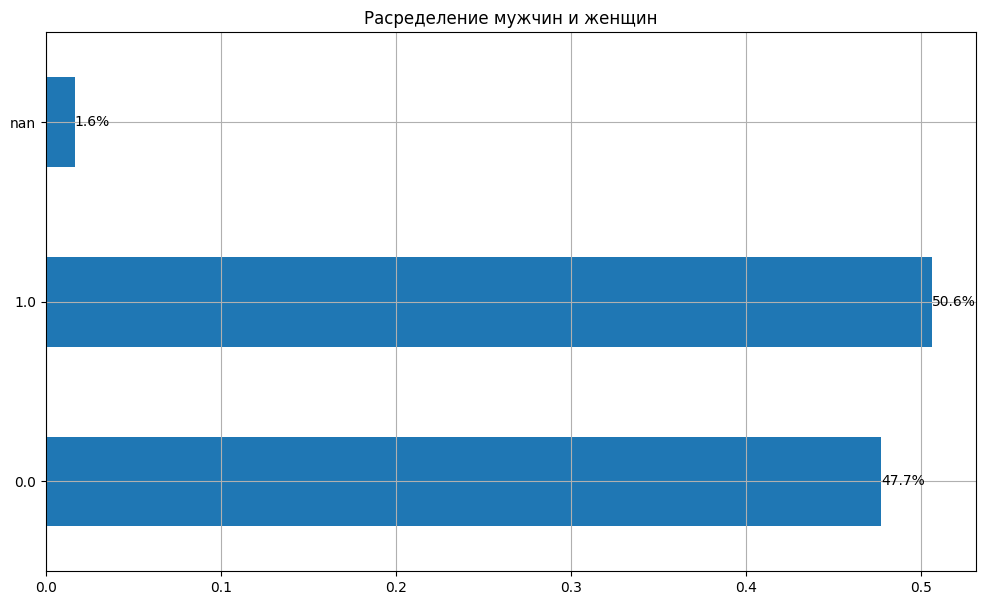

In [9]:
# Calling a bar chart vizualisation for users.csv by sex column
plot_normalized_barh_chart(users, 'sex', 'Расределение мужчин и женщин')

### Items

In [10]:
items.head()

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
1,2508,film,Голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",США,NaN,16.0,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео..."
2,10716,film,Тактическая сила,Tactical Force,2011.0,"криминал, зарубежные, триллеры, боевики, комедии",Канада,NaN,16.0,NaN,Адам П. Калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг..."
3,7868,film,45 лет,45 Years,2015.0,"драмы, зарубежные, мелодрамы",Великобритания,NaN,16.0,NaN,Эндрю Хэй,"Александра Риддлстон-Барретт, Джеральдин Джейм...","Шарлотта Рэмплинг, Том Кортни, Джеральдин Джей...","45, лет, 2015, Великобритания, брак, жизнь, лю..."
4,16268,film,Все решает мгновение,NaN,1978.0,"драмы, спорт, советские, мелодрамы",СССР,NaN,12.0,Ленфильм,Виктор Садовский,"Александр Абдулов, Александр Демьяненко, Алекс...",Расчетливая чаровница из советского кинохита «...,"Все, решает, мгновение, 1978, СССР, сильные, ж..."


In [11]:
# Counting a unique items number
print(f'Всего уникальных айтемов: {items[Columns.Item].nunique():,}')

Всего уникальных айтемов: 15,963


In [12]:
# Statistics of items' release year
# bins == all items released before 1990
YEAR_FROM = 1990
STEP_SIZE = 5
bins = [year for year in range (YEAR_FROM, int(items['release_year'].max()) + STEP_SIZE, STEP_SIZE)]

In [13]:
bins = [int(items['release_year'].min())] + bins

In [14]:
items['year_bin'] = pd.cut(items['release_year'],
                          bins = bins, include_lowest = True)

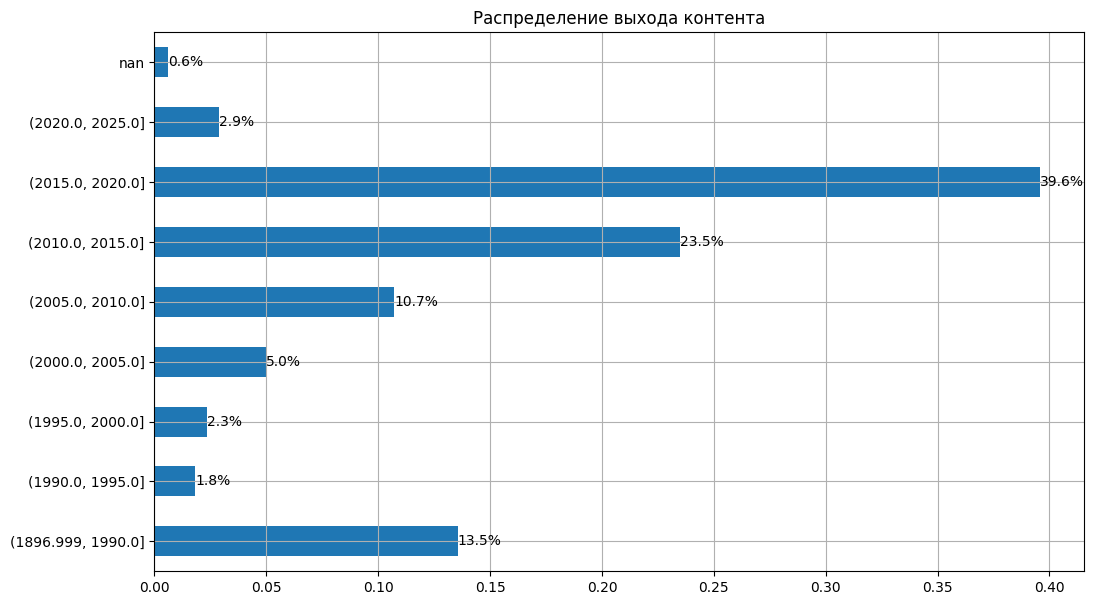

In [15]:
plot_normalized_barh_chart(items, 'year_bin', 'Распределение выхода контента')

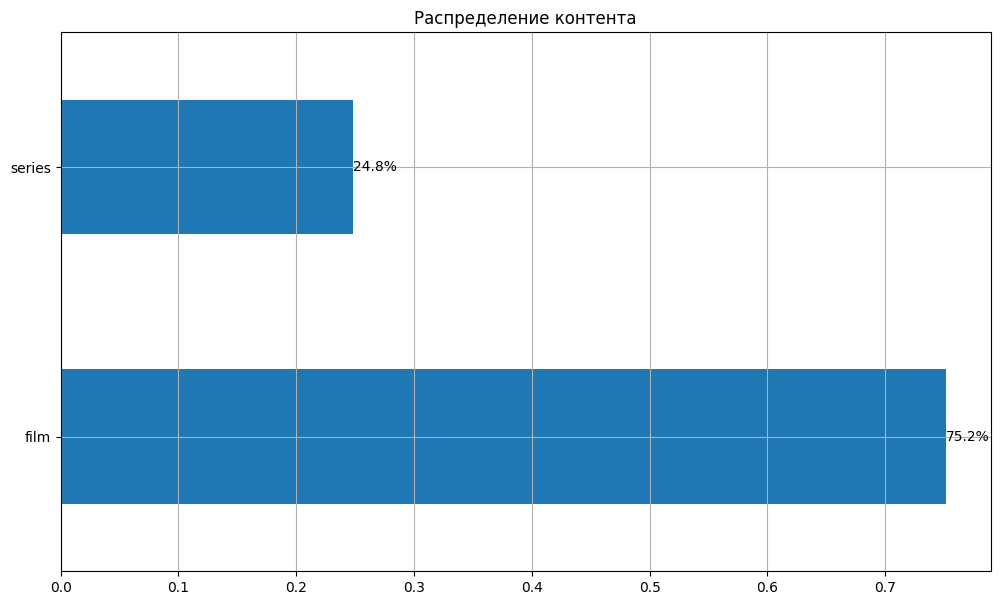

In [16]:
plot_normalized_barh_chart(items, 'content_type', 'Распределение контента')

### Interactions

In [17]:
interactions.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


In [18]:
# Fixing column name and making objects iterable
Columns.Datetime = 'last_watch_dt'

In [19]:
# Excluding datetime objects with incorrect date format
interactions.drop(interactions[interactions[Columns.Datetime].str.len() != 10].index, inplace=True)

In [20]:
# Number interactions
interactions[Columns.Datetime].str.len().value_counts()

10    5476251
Name: last_watch_dt, dtype: int64

In [21]:
interactions[Columns.Datetime].min(), interactions[Columns.Datetime].max()

('2021-03-13', '2021-08-22')

In [22]:
interactions

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0
...,...,...,...,...,...
5476246,648596,12225,2021-08-13,76,0.0
5476247,546862,9673,2021-04-13,2308,49.0
5476248,697262,15297,2021-08-20,18307,63.0
5476249,384202,16197,2021-04-19,6203,100.0


# 3. Train/Test split

In [23]:
#Convert str-Datetime to pd-Datetime object
interactions[Columns.Datetime] = pd.to_datetime(interactions[Columns.Datetime], format='%Y-%m-%d')

In [24]:
#The max date of interactions
max_date = interactions[Columns.Datetime].max()

In [25]:
#Sort interactions by duration
interactions['total_dur'].describe(percentiles=[.01,.1,.5,.9,.99]).round(2)

count     5476251.00
mean         8295.49
std         48567.99
min             1.00
1%              3.00
10%            42.00
50%          2898.00
90%         15112.00
99%         90083.00
max      80411672.00
Name: total_dur, dtype: float64

In [26]:
#If user's interacted with item more than(or directly) 10%==3, else 1
interactions[Columns.Weight] = np.where(interactions['watched_pct'] > 10, 3, 1)

In [27]:
#Describe count of interactions by Weight
interactions[Columns.Weight].value_counts(normalize=True)

3    0.660172
1    0.339828
Name: weight, dtype: float64

In [28]:
#Split test/train interaction by DateTime
# test == all the last week interactions before max_date (cold_users included)
# train == all the other interactions (cold_users excluded)
train = interactions[interactions[Columns.Datetime] < max_date - pd.Timedelta(days=7)].copy()
test = interactions[interactions[Columns.Datetime] >= max_date - pd.Timedelta(days=7)].copy()

print(f"train: {train.shape}")
print(f"test: {test.shape}")

train: (4985269, 6)
test: (490982, 6)


In [29]:
#Drop out items["total_dur"] less that 300 from train
train.drop(train.query("total_dur < 300").index, inplace=True)

In [30]:
# Take out of account all cold_users
cold_users = set(test[Columns.User]) - set(train[Columns.User])

In [31]:
test.drop(test[test[Columns.User].isin(cold_users)].index, inplace=True)

# 4. Features

### User features

In [32]:
users.isnull().sum()

user_id         0
age         14095
income      14776
sex         13831
kids_flg        0
dtype: int64

In [33]:
# Replacing a Null values
users.fillna("Unknown", inplace = True)
users.nunique()

user_id     840197
age              7
income           7
sex              3
kids_flg         2
dtype: int64

In [34]:
# copying df and locing on users in train df
users = users.loc[users[Columns.User].isin(train[Columns.User])].copy()

In [35]:
users

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,0.0,1
1,962099,age_18_24,income_20_40,0.0,0
3,721985,age_45_54,income_20_40,1.0,0
4,704055,age_35_44,income_60_90,1.0,0
5,1037719,age_45_54,income_60_90,0.0,0
...,...,...,...,...,...
840184,529394,age_25_34,income_40_60,1.0,0
840186,80113,age_25_34,income_40_60,1.0,0
840188,312839,age_65_inf,income_60_90,1.0,0
840189,191349,age_45_54,income_40_60,0.0,1


In [36]:
# creating a user_feature_frame
user_features_frames = []
for feature in ["sex", "age", "income"]:
    feature_frame = users.reindex(columns=[Columns.User, feature])
    feature_frame.columns = ["id", "value"]
    feature_frame["feature"] = feature
    user_features_frames.append(feature_frame)
user_features = pd.concat(user_features_frames)
user_features

,id,value,feature
0,973171,0.0,sex
1,962099,0.0,sex
3,721985,1.0,sex
4,704055,1.0,sex
5,1037719,0.0,sex
...,...,...,...
840184,529394,income_40_60,income
840186,80113,income_40_60,income
840188,312839,income_60_90,income
840189,191349,income_40_60,income


### Item features

In [37]:
items.isnull().sum()

item_id             0
content_type        0
title               0
title_orig       4745
release_year       98
genres              0
countries          37
for_kids        15397
age_rating          2
studios         14898
directors        1509
actors           2619
description         2
keywords          423
year_bin           98
dtype: int64

In [38]:
items = items.loc[items[Columns.Item].isin(train[Columns.Item])].copy()
items

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords,year_bin
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ...","(2000.0, 2005.0]"
1,2508,film,Голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",США,NaN,16.0,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео...","(2010.0, 2015.0]"
2,10716,film,Тактическая сила,Tactical Force,2011.0,"криминал, зарубежные, триллеры, боевики, комедии",Канада,NaN,16.0,NaN,Адам П. Калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг...","(2010.0, 2015.0]"
3,7868,film,45 лет,45 Years,2015.0,"драмы, зарубежные, мелодрамы",Великобритания,NaN,16.0,NaN,Эндрю Хэй,"Александра Риддлстон-Барретт, Джеральдин Джейм...","Шарлотта Рэмплинг, Том Кортни, Джеральдин Джей...","45, лет, 2015, Великобритания, брак, жизнь, лю...","(2010.0, 2015.0]"
4,16268,film,Все решает мгновение,NaN,1978.0,"драмы, спорт, советские, мелодрамы",СССР,NaN,12.0,Ленфильм,Виктор Садовский,"Александр Абдулов, Александр Демьяненко, Алекс...",Расчетливая чаровница из советского кинохита «...,"Все, решает, мгновение, 1978, СССР, сильные, ж...","(1896.999, 1990.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15958,6443,series,Полярный круг,Arctic Circle,2018.0,"драмы, триллеры, криминал","Финляндия, Германия",NaN,16.0,NaN,Ханну Салонен,"Иина Куустонен, Максимилиан Брюкнер, Пихла Вии...","Во время погони за браконьерами по лесу, сотру...","убийство, вирус, расследование преступления, н...","(2015.0, 2020.0]"
15959,2367,series,Надежда,NaN,2020.0,"драмы, боевики",Россия,0.0,18.0,NaN,Елена Хазанова,"Виктория Исакова, Александр Кузьмин, Алексей М...",Оригинальный киносериал от создателей «Бывших»...,"Надежда, 2020, Россия","(2015.0, 2020.0]"
15960,10632,series,Сговор,Hassel,2017.0,"драмы, триллеры, криминал",Россия,0.0,18.0,NaN,"Эшреф Рейбрук, Амир Камдин, Эрик Эгер","Ола Рапас, Алиетт Офейм, Уильма Лиден, Шанти Р...",Криминальная драма по мотивам романов о шведск...,"Сговор, 2017, Россия","(2015.0, 2020.0]"
15961,4538,series,Среди камней,Darklands,2019.0,"драмы, спорт, криминал",Россия,0.0,18.0,NaN,"Марк О’Коннор, Конор МакМахон","Дэйн Уайт О’Хара, Томас Кэйн-Бирн, Джудит Родд...",Семнадцатилетний Дэмиен мечтает вырваться за п...,"Среди, камней, 2019, Россия","(2015.0, 2020.0]"


In [39]:
# Explode genres feature to flatten table
items["genre"] = items["genres"].str.lower().str.replace(", ", ",", regex=False).str.split(",")
genre_feature = items[["item_id", "genre"]].explode("genre")
genre_feature.columns = ["id", "value"]
genre_feature["feature"] = "genre"
genre_feature.head()

,id,value,feature
0,10711,драмы,genre
0,10711,зарубежные,genre
0,10711,детективы,genre
0,10711,мелодрамы,genre
1,2508,зарубежные,genre


In [40]:
# Explode content feature to flatten table
content_feature = items.reindex(columns=[Columns.Item, "content_type"])
content_feature.columns = ["id", "value"]
content_feature["feature"] = "content_type"
content_feature.head()

,id,value,feature
0,10711,film,content_type
1,2508,film,content_type
2,10716,film,content_type
3,7868,film,content_type
4,16268,film,content_type


In [41]:
# Concatenating features
item_features = pd.concat((genre_feature, content_feature))
item_features.head()

,id,value,feature
0,10711,драмы,genre
0,10711,зарубежные,genre
0,10711,детективы,genre
0,10711,мелодрамы,genre
1,2508,зарубежные,genre


In [42]:
users_inv_mapping = dict(enumerate(train['user_id'].unique()))
users_mapping = {v: k for k, v in users_inv_mapping.items()}

items_inv_mapping = dict(enumerate(train['item_id'].unique()))
items_mapping = {v: k for k, v in items_inv_mapping.items()}

print(f"users_mapping amount: {len(users_mapping)}")
print(f"items_mapping amount: {len(items_mapping)}")

users_mapping amount: 756562
items_mapping amount: 14019


# 5. ALS, BPR

In [43]:
K_RECOS = 10
RANDOM_STATE = 42
N_FACTORS = (4, 16, 32)
N_EPOCHS = 1 # Lightfm
USER_ALPHA = 0 # Lightfm
ITEM_ALPHA = 0 # Lightfm
LEARNING_RATE = 0.05 # Lightfm

In [44]:
dataset = Dataset.construct(
    interactions_df=train,
    user_features_df=user_features,
    cat_user_features=["sex", "age", "income"],
    item_features_df=item_features,
    cat_item_features=["genre", "content_type"],
)

In [45]:
TEST_USERS = test[Columns.User].unique()

In [46]:
# models from implicit
models = {}

implicit_models = {
    'ALS': AlternatingLeastSquares,
}
for implicit_name, implicit_model in implicit_models.items():
    for is_fitting_features in (True, False):
        for n_factors in N_FACTORS:
            models[f"{implicit_name}_{n_factors}_{is_fitting_features}"] = (
                ImplicitALSWrapperModel(
                model=implicit_model(
                    factors=n_factors, 
                    random_state=RANDOM_STATE, 
                ),
                fit_features_together = is_fitting_features,
            )
        )

In [47]:
# models from lightfm

lightfm_losses = ('logistic', 'bpr', 'warp')

for loss in lightfm_losses:
    for n_factors in N_FACTORS:
        models[f"LightFM_{loss}_{n_factors}"] = LightFMWrapperModel(
            LightFM(
                no_components=n_factors, 
                loss=loss, 
                random_state=RANDOM_STATE,
                learning_rate=LEARNING_RATE,
                user_alpha=USER_ALPHA,
                item_alpha=ITEM_ALPHA,
            ),
            epochs=N_EPOCHS,
        )

In [48]:
models

{'ALS_4_True': <rectools.models.implicit_als.ImplicitALSWrapperModel at 0x7fbf948de790>,
 'ALS_16_True': <rectools.models.implicit_als.ImplicitALSWrapperModel at 0x7fbf948de220>,
 'ALS_32_True': <rectools.models.implicit_als.ImplicitALSWrapperModel at 0x7fbf948de850>,
 'ALS_4_False': <rectools.models.implicit_als.ImplicitALSWrapperModel at 0x7fbf948de2e0>,
 'ALS_16_False': <rectools.models.implicit_als.ImplicitALSWrapperModel at 0x7fbf948de0a0>,
 'ALS_32_False': <rectools.models.implicit_als.ImplicitALSWrapperModel at 0x7fbf948de040>,
 'LightFM_logistic_4': <rectools.models.lightfm.LightFMWrapperModel at 0x7fbf948de280>,
 'LightFM_logistic_16': <rectools.models.lightfm.LightFMWrapperModel at 0x7fbf948de490>,
 'LightFM_logistic_32': <rectools.models.lightfm.LightFMWrapperModel at 0x7fbf948de700>,
 'LightFM_bpr_4': <rectools.models.lightfm.LightFMWrapperModel at 0x7fbf948de940>,
 'LightFM_bpr_16': <rectools.models.lightfm.LightFMWrapperModel at 0x7fbf948dea00>,
 'LightFM_bpr_32': <rectoo

In [49]:
# metrics
metrics_name = {
    'Precision': Precision,
    'Recall': Recall,
    'MAP': MAP,
}

metrics = {}
for metric_name, metric in metrics_name.items():
    for k in range(1, 10+1):
        metrics[f'{metric_name}@{k}'] = metric(k=k)

In [50]:
metrics

{'Precision@1': Precision(k=1),
 'Precision@2': Precision(k=2),
 'Precision@3': Precision(k=3),
 'Precision@4': Precision(k=4),
 'Precision@5': Precision(k=5),
 'Precision@6': Precision(k=6),
 'Precision@7': Precision(k=7),
 'Precision@8': Precision(k=8),
 'Precision@9': Precision(k=9),
 'Precision@10': Precision(k=10),
 'Recall@1': Recall(k=1),
 'Recall@2': Recall(k=2),
 'Recall@3': Recall(k=3),
 'Recall@4': Recall(k=4),
 'Recall@5': Recall(k=5),
 'Recall@6': Recall(k=6),
 'Recall@7': Recall(k=7),
 'Recall@8': Recall(k=8),
 'Recall@9': Recall(k=9),
 'Recall@10': Recall(k=10),
 'MAP@1': MAP(k=1, divide_by_k=False),
 'MAP@2': MAP(k=2, divide_by_k=False),
 'MAP@3': MAP(k=3, divide_by_k=False),
 'MAP@4': MAP(k=4, divide_by_k=False),
 'MAP@5': MAP(k=5, divide_by_k=False),
 'MAP@6': MAP(k=6, divide_by_k=False),
 'MAP@7': MAP(k=7, divide_by_k=False),
 'MAP@8': MAP(k=8, divide_by_k=False),
 'MAP@9': MAP(k=9, divide_by_k=False),
 'MAP@10': MAP(k=10, divide_by_k=False)}

In [61]:
models_dir = Path('../models')
models_dir.mkdir(exist_ok=True)

results = []
for model_name, model in models.items():
    print(f"Fitting model {model_name}...")
    model_quality = {'model': model_name}

    model.fit(dataset)
    with open(models_dir / f'{model_name}.dill', 'wb') as f:
        dill.dump(model, f)
    recos = model.recommend(
        users=TEST_USERS,
        dataset=dataset,
        k=K_RECOS,
        filter_viewed=True,
    )
    metric_values = calc_metrics(metrics, recos, test, train)
    model_quality.update(metric_values)
    results.append(model_quality)

Fitting model ALS_4_True...
Fitting model ALS_16_True...


/home/mikhail/Documents/DL/ITMORecoService_32/.venv/lib/python3.8/site-packages/rectools/dataset/features.py:399: UserWarning: Converting sparse features to dense array may cause MemoryError
  warnings.warn("Converting sparse features to dense array may cause MemoryError")


Fitting model ALS_32_True...


/home/mikhail/Documents/DL/ITMORecoService_32/.venv/lib/python3.8/site-packages/rectools/dataset/features.py:399: UserWarning: Converting sparse features to dense array may cause MemoryError
  warnings.warn("Converting sparse features to dense array may cause MemoryError")


Fitting model ALS_4_False...


/home/mikhail/Documents/DL/ITMORecoService_32/.venv/lib/python3.8/site-packages/rectools/dataset/features.py:399: UserWarning: Converting sparse features to dense array may cause MemoryError
  warnings.warn("Converting sparse features to dense array may cause MemoryError")


Fitting model ALS_16_False...


/home/mikhail/Documents/DL/ITMORecoService_32/.venv/lib/python3.8/site-packages/rectools/dataset/features.py:399: UserWarning: Converting sparse features to dense array may cause MemoryError
  warnings.warn("Converting sparse features to dense array may cause MemoryError")


Fitting model ALS_32_False...


/home/mikhail/Documents/DL/ITMORecoService_32/.venv/lib/python3.8/site-packages/rectools/dataset/features.py:399: UserWarning: Converting sparse features to dense array may cause MemoryError
  warnings.warn("Converting sparse features to dense array may cause MemoryError")


Fitting model LightFM_logistic_4...
Fitting model LightFM_logistic_16...
Fitting model LightFM_logistic_32...
Fitting model LightFM_bpr_4...
Fitting model LightFM_bpr_16...
Fitting model LightFM_bpr_32...
Fitting model LightFM_warp_4...
Fitting model LightFM_warp_16...
Fitting model LightFM_warp_32...


In [64]:
# Creating a df and highlighting highest result in a row
df_quality = pd.DataFrame(results).T
df_quality.columns = df_quality.iloc[0]
df_quality.drop('model', inplace=True)

In [65]:
df_quality.style.highlight_max(color='lightgreen', axis=1)

model,ALS_4_True,ALS_16_True,ALS_32_True,ALS_4_False,ALS_16_False,ALS_32_False,LightFM_logistic_4,LightFM_logistic_16,LightFM_logistic_32,LightFM_bpr_4,LightFM_bpr_16,LightFM_bpr_32,LightFM_warp_4,LightFM_warp_16,LightFM_warp_32
Precision@1,0.079839,0.081379,0.081043,0.072953,0.058676,0.061021,0.000363,0.000363,0.000363,0.028962,0.033210,0.033564,0.081433,0.079653,0.079804
Recall@1,0.040853,0.041867,0.041905,0.036633,0.028896,0.030265,0.000116,0.000116,0.000116,0.016639,0.019000,0.019221,0.041697,0.040503,0.040512
Precision@2,0.068200,0.069195,0.068961,0.063787,0.053710,0.054361,0.000469,0.000469,0.000469,0.019849,0.023969,0.024660,0.067965,0.068983,0.069364
Recall@2,0.068557,0.069732,0.069409,0.063528,0.052244,0.053263,0.000301,0.000301,0.000301,0.022370,0.026595,0.027518,0.068025,0.068443,0.069145
Precision@3,0.059652,0.059753,0.059425,0.057100,0.049594,0.050435,0.000434,0.000313,0.000313,0.015215,0.018653,0.019697,0.059776,0.062042,0.062125
Recall@3,0.088229,0.088386,0.087776,0.084089,0.071360,0.073058,0.000473,0.000301,0.000301,0.025505,0.030642,0.032315,0.088296,0.091157,0.091500
Precision@4,0.052843,0.053252,0.052741,0.051024,0.046405,0.046731,0.000354,0.000350,0.000237,0.012556,0.015397,0.016497,0.054367,0.055845,0.055861
Recall@4,0.102719,0.103579,0.102545,0.098638,0.088156,0.089611,0.000512,0.000514,0.000302,0.027625,0.033269,0.035609,0.106091,0.108316,0.108380
Precision@5,0.047307,0.047507,0.047126,0.046238,0.043391,0.043133,0.000290,0.000299,0.000197,0.010623,0.013265,0.014093,0.049428,0.050715,0.050488
Recall@5,0.113988,0.114334,0.113141,0.110624,0.101862,0.101747,0.000531,0.000528,0.000318,0.028907,0.035516,0.037741,0.119280,0.121963,0.121249


## Load saved models

In [52]:
models_dir = Path('../models')

for model_name in tqdm(models.keys()):
    with open(models_dir / f'{model_name}.dill', 'rb') as f:
        models[model_name] = dill.load(f)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 17.20it/s]


# 6. Recs via ANN

## По метрикам лучше всего выглядят модели LightFMWarp, выберем LightFM_warp_16

In [53]:
best_model = models['LightFM_warp_16']

In [55]:
user_embeddings, item_embeddings = best_model.get_vectors(dataset)

In [56]:
print(f'user_embeddings: {user_embeddings.shape}, item_embeddings: {item_embeddings.shape}')

user_embeddings: (756562, 18), item_embeddings: (14019, 18)


In [57]:
def augment_inner_product(factors):
    normed_factors = np.linalg.norm(factors, axis=1)
    max_norm = normed_factors.max()
    
    extra_dim = np.sqrt(max_norm ** 2 - normed_factors ** 2).reshape(-1, 1)
    augmented_factors = np.append(factors, extra_dim, axis=1)
    return max_norm, augmented_factors

In [58]:
print('pre shape: ', item_embeddings.shape)
max_norm, augmented_item_embeddings = augment_inner_product(item_embeddings)
augmented_item_embeddings.shape

pre shape:  (14019, 18)


(14019, 19)

In [59]:
extra_zero = np.zeros((user_embeddings.shape[0], 1))
augmented_user_embeddings = np.append(user_embeddings, extra_zero, axis=1)
augmented_user_embeddings.shape

(756562, 19)

## Для получения оффлайн рекомендаций используем NMSLIB

### Set parameters

In [60]:
# Set index parameters
# These are the most important ones
M = 48
efC = 100

num_threads = 4
index_time_params = {'M': M, 'indexThreadQty': num_threads, 'efConstruction': efC, 'post' : 0}
print('Index-time parameters', index_time_params)

Index-time parameters {'M': 48, 'indexThreadQty': 4, 'efConstruction': 100, 'post': 0}


In [61]:
# Number of neighbors 
K=10

# Space name should correspond to the space name 
# used for brute-force search
space_name='negdotprod'

# Intitialize the library, specify the space, the type of the vector and add data points 
index = nmslib.init(method='hnsw', space=space_name, data_type=nmslib.DataType.DENSE_VECTOR) 
index.addDataPointBatch(augmented_item_embeddings) 

14019

In [62]:
# Create an index
start = time.time()
index_time_params = {'M': M, 'indexThreadQty': num_threads, 'efConstruction': efC}
index.createIndex(index_time_params) 
end = time.time() 
print('Index-time parameters', index_time_params)
print('Indexing time = %f' % (end-start))

Index-time parameters {'M': 48, 'indexThreadQty': 4, 'efConstruction': 100}
Indexing time = 0.136509


In [63]:
# Setting query-time parameters
efS = 100
query_time_params = {'efSearch': efS}
print('Setting query-time parameters', query_time_params)
index.setQueryTimeParams(query_time_params)

Setting query-time parameters {'efSearch': 100}


In [64]:
# Querying
query_qty = augmented_user_embeddings.shape[0]
start = time.time() 
nbrs = index.knnQueryBatch(augmented_user_embeddings, k = K, num_threads = num_threads)
end = time.time() 
print('kNN time total=%f (sec), per query=%f (sec), per query adjusted for thread number=%f (sec)' % 
      (end-start, float(end-start)/query_qty, num_threads*float(end-start)/query_qty)) 

kNN time total=3.216093 (sec), per query=0.000004 (sec), per query adjusted for thread number=0.000017 (sec)


## Save offline recs

In [65]:
recommendations = {users_inv_mapping[i]: [items_inv_mapping[r] for r in pred[0]] for i, pred in enumerate(nbrs)}

In [66]:
import pickle
with open(models_dir / f'offline_ann_recs.pkl', 'wb') as f:
    pickle.dump(recommendations, f, protocol=pickle.HIGHEST_PROTOCOL)